## Imports

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.utils import compute_class_weight

from preprocessor import *
from data import *

In [11]:
def learning_curve_plot(model):
    # Compute the learning curve
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, 
                                                            train_sizes=np.linspace(0.1, 1.0, 20), 
                                                            cv=5, n_jobs=-1, verbose=1)

    # Calculate the mean and standard deviation of train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation Score', color='green')

    # Plot the standard deviation as shaded area
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

    # Add labels and title
    plt.title('RandomForest Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')

    # Show the plot
    plt.show()

In [2]:
## import data when available
data = pd.read_csv('data/wingman_data_proc_v5.csv')
data.set_index('id', inplace=True)

In [16]:
data.shape

(5871, 58)

## Train test split

In [3]:
X = data.drop('subcategory_no', axis=1)
y = data['subcategory_no']

In [4]:
# Identify the numerical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Create a StandardScaler object
scaler = RobustScaler()

# Standardize the numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## SMOTE

In [6]:
from imblearn.over_sampling import SMOTE

# Assuming your dataset is stored in X and y variables
# X should contain the features, and y should contain the corresponding labels

# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the dataset
X_smote, y_smote = smote.fit_resample(X_train, y_train)

## Baseline model

In [7]:
baseline_model = RandomForestClassifier(random_state=42)

baseline_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
y_pred = baseline_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.5357548240635641

## RandomForestClassifier

In [9]:
random_forest = RandomForestClassifier(bootstrap=False, max_depth=168, 
                                       max_features='sqrt', min_samples_leaf=15, 
                                       min_samples_split=5, n_estimators=2500)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.5510783200908059

[learning_curve] Training set sizes: [ 469  692  914 1136 1359 1581 1804 2026 2249 2471 2694 2916 3138 3361
 3583 3806 4028 4251 4473 4696]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


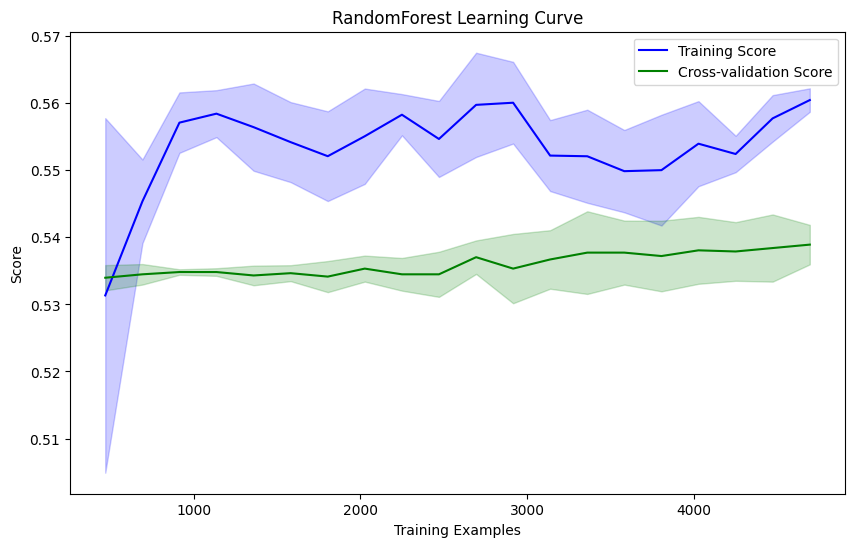

In [15]:
learning_curve_plot(random_forest)

## AdaBoost

### Base Adaboost

In [10]:
# Create an Adaboost classifier
adaboost = AdaBoostClassifier(estimator=random_forest,
                              n_estimators=5, 
                              random_state=42)

# Train the Adaboost classifier
adaboost.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = adaboost.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5516458569807038


[learning_curve] Training set sizes: [ 469  692  914 1136 1359 1581 1804 2026 2249 2471 2694 2916 3138 3361
 3583 3806 4028 4251 4473 4696]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


/Users/sarajagantner/.pyenv/versions/3.10.6/envs/wingman/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.5min finished


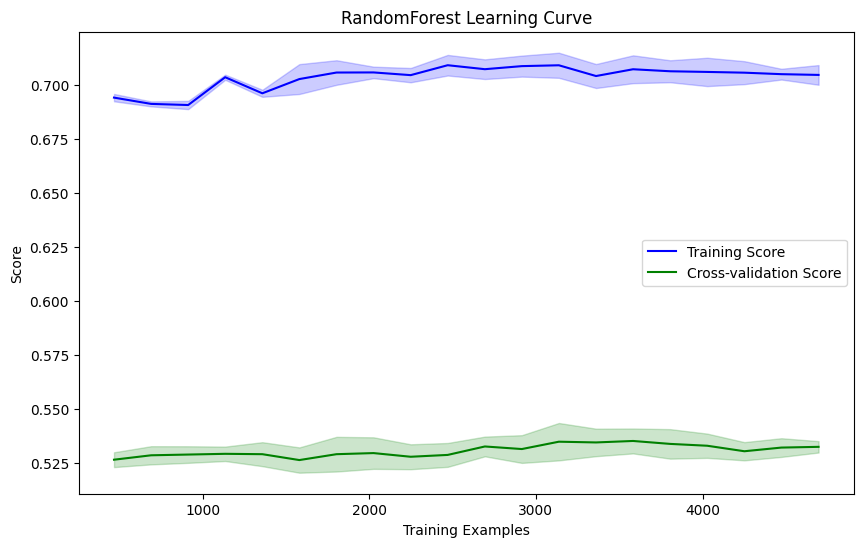

In [12]:
learning_curve_plot(adaboost)

## Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

<Axes: >

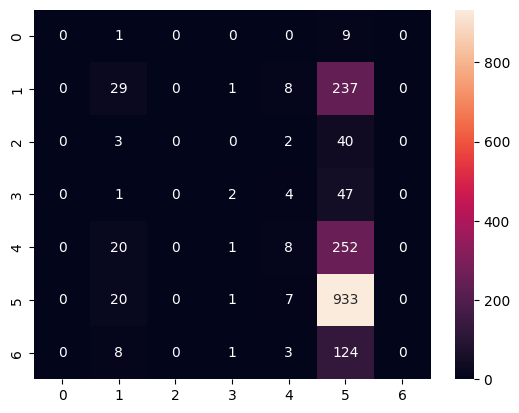

In [14]:
sns.heatmap(cm, annot=True, fmt='g')